In [ ]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import re

project_root = "/home/ubuntu/VOCAL-UDF/"

config = yaml.safe_load(open(os.path.join(project_root, "configs", "config.yaml"), "r"))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

######## gpt-4o ########


mean_f1: 0.2936786035426968

######## vocal-udf ########
task_0_new_udfs_mean_f1: 0.9718162839248434
task_0_new_udfs_prob_failures: 0.0

task_1_new_udfs_mean_f1: 0.8266938300191311
task_1_new_udfs_prob_failures: 0.0

task_2_new_udfs_mean_f1: 0.819486099779543
task_2_new_udfs_prob_failures: 0.0

task_3_new_udfs_mean_f1: 0.7718633026568696
task_3_new_udfs_prob_failures: 0.0



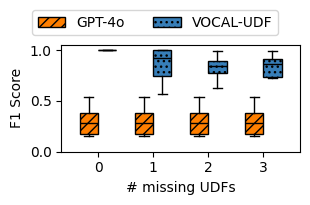

vanilla LLM estimated_cost: [5.164999999999996, 5.174375000000014, 5.169374999999956, 5.164375000000067, 5.176875000000045, 5.164999999999996, 5.170625000000004, 5.159374999999993, 5.168124999999977, 5.1584125000000265], mean: 5.167153750000007, count: 10


In [ ]:
def plot():
    CB_color_cycle = ['#ff7f00', '#377eb8', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    dataset = "clevrer"
    query_class_names = ["simplified_3_new_udfs_labels"]
    question_ids = list(range(10))
    vocal_udf_run_ids = list(range(1))
    gpt4o_run_ids = list(range(1))
    num_new_udfs = [0, 1, 2, 3]
    vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=both-budget=20-llm_method=gpt"

    # Define LLM models, tasks, number of new UDFs, and hatch patterns
    llm_models = ['gpt-4o', 'vocal-udf']
    llm_model_labels = ['GPT-4o', 'VOCAL-UDF']

    hatch_patterns = ['///', '...', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']
    handles_f1 = []

    # Create a figure and axis for the boxplot
    fig, ax = plt.subplots(1, 1, figsize=(len(num_new_udfs)*0.8, 1.8))  # Adjust the figsize as needed

    estimated_cost_data = []
    # Iterate through LLM models
    for i, llm_model in enumerate(llm_models):
        print(f"######## {llm_model} ########")
        f1_data = []
        if llm_model == "gpt-4o":
            f1_list = []
            for query_class_name in query_class_names:
                for run_id in gpt4o_run_ids:
                    for question_id in question_ids:
                        try:
                            with open(os.path.join(config['log_dir'], "gpt4o_clevrer_simplified", query_class_name, f"batch_job_results_qid={question_id}-run={run_id}.log"), "r") as f:
                                lines = f.readlines()
                            f1_score = float(lines[-2].split("F1 score: ")[1])
                            estimated_cost = float(lines[-1].split("estimated_cost: ")[1])
                            f1_list.append(f1_score)
                            estimated_cost_data.append(estimated_cost)
                        except Exception as e:
                            print(e)
                            continue
            print(f"mean_f1: {np.mean(f1_list)}")
            print()
            for task_id in num_new_udfs:
                f1_data.append(f1_list)
        else:
            # Iterate through tasks
            for task_id in num_new_udfs:
                task = f"{task_id}_new_udfs"
                f1_list = []
                failed_list = []

                # Iterate through runs and questions
                for query_class_name in query_class_names:
                    for run_id in vocal_udf_run_ids:
                        for question_id in question_ids:
                            try:
                                with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={task_id}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                                    lines = f.readlines()
                                f1_score = -1
                                for line in lines:
                                    if "F1 score:" in line:
                                        f1_score_pattern = r"F1 score: ([0-9.]+)"
                                        match = re.search(f1_score_pattern, line)
                                        f1_score = float(match.group(1))
                                        failed_list.append(0)
                                        break
                                if f1_score == -1:
                                    print(f"failed task: qid={question_id}-run={run_id}")
                                    failed_list.append(1)
                                    f1_score = 0
                                f1_list.append(f1_score)
                            except Exception as e:
                                print(e)
                                continue

                f1_data.append(f1_list)
                print(f"task_{task}_mean_f1: {np.mean(f1_list)}")
                print(f"task_{task}_prob_failures: {np.mean(failed_list)}")
                print()

        # Create a grouped boxplot for F1 scores
        bp_f1 = ax.boxplot(f1_data,
                        positions=np.array(range(len(f1_data))) * (len(llm_models) + 1) + i,
                        sym='.',
                        widths=1,
                        showfliers=False,
                        patch_artist=True,
                        boxprops=dict(facecolor=CB_color_cycle[i], hatch=hatch_patterns[i]),
                        medianprops=dict(color='black'))
        handles_f1.append(bp_f1["boxes"][0])

    # Customize the plot labels and legend
    # ax.set_title(f"question_ids: {question_ids}")
    ax.set(ylabel="F1 Score")
    ax.set(xlabel="# missing UDFs")
    ax.set_ylim(bottom=0, top=1.05)
    ax.set_xlim(left=-1.5, right=len(num_new_udfs) * (len(llm_models) + 1) - 0.5)
    ax.set_xticks(np.arange(len(llm_models) / 2 - 0.5, len(num_new_udfs) * len(llm_models) + len(llm_models) / 2 + 1, len(llm_models) + 1))
    ax.set_xticklabels(num_new_udfs)
    # fig.legend(handles_f1, llm_model_labels, loc='center left', bbox_to_anchor=(1, 0.6), ncol=1, prop={"size": 10}, fancybox=True, shadow=False) # On the right
    fig.legend(handles_f1, llm_model_labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, prop={"size": 10}, fancybox=True, shadow=False) # On the top
    fig.tight_layout()
    fig.savefig(f"figures/llm_basline.pdf", bbox_inches='tight')

    plt.show()

    print(f"vanilla LLM estimated_cost: {estimated_cost_data}, mean: {np.mean(estimated_cost_data)}, count: {len(estimated_cost_data)}")
plot()

medians: [1.0, 0.957974478062858, 0.825268817204301, 0.5097402597402597]


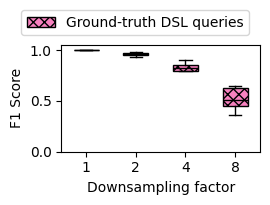

In [7]:
def plot():
    CB_color_cycle = ['#f781bf', '#377eb8', '#ff7f00', '#4daf4a',
                  '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
    question_ids = list(range(10))
    sampling_rates = [1, 2, 4, 8]

    hatch_patterns = ['xxx', '...', '///', '\\\\\\', '***', '+++', '|||', '---', 'ooo']
    handles_f1 = []

    # Create a figure and axis for the boxplot
    fig, ax = plt.subplots(1, 1, figsize=(len(sampling_rates)*0.7, 1.8))  # Adjust the figsize as needed

    f1_data = []
    for sampling_rate in sampling_rates:
        f1_list = []
        for question_id in question_ids:
            try:
                with open(os.path.join(config['log_dir'], "oracle_clevrer_simplified", "simplified_3_new_udfs_labels", f"qid={question_id}-sampling_rate={sampling_rate}.log"), "r") as f:
                    lines = f.readlines()
                f1_score = -1
                for line in lines:
                    if "F1 score:" in line:
                        f1_score_pattern = r"F1 score: ([0-9.]+)"
                        match = re.search(f1_score_pattern, line)
                        f1_score = float(match.group(1))
                        break
                if f1_score == -1:
                    print(f"failed task: qid={question_id}-sampling_rate={sampling_rate}")
                    f1_score = 0
                f1_list.append(f1_score)
            except Exception as e:
                print(e)
                continue
        f1_data.append(f1_list)

    # Create a grouped boxplot for F1 scores
    bp_f1 = ax.boxplot(f1_data,
                    positions=np.array(range(len(f1_data))) * 2,
                    sym='.',
                    widths=1,
                    showfliers=False,
                    patch_artist=True,
                    boxprops=dict(facecolor=CB_color_cycle[0], hatch=hatch_patterns[0]),
                    medianprops=dict(color='black'))
    handles_f1.append(bp_f1["boxes"][0])

    # # Extract the median values
    medians = [median.get_ydata()[0] for median in bp_f1['medians']]
    print(f"medians: {medians}")

    # # Plot a line (and/or markers) connecting the medians
    # ax.plot(range(0, len(f1_data) * 2, 2), medians, color='black', label='Median')

    # Customize the plot labels and legend
    # ax.set_title(f"Ground-truth DSL", fontsize=10, fontweight='bold')
    ax.set(ylabel="F1 Score")
    ax.set(xlabel="Downsampling factor")
    ax.set_ylim(bottom=0, top=1.05)
    ax.set_xlim(left=-1, right=len(sampling_rates) * 2 - 1)
    # ax.set_xticks(np.arange(0, len(sampling_rates) + 0.5 + 1, 1 + 1))
    ax.set_xticklabels(sampling_rates)
    fig.legend(handles_f1, ['Ground-truth DSL queries'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=1, prop={"size": 10}, fancybox=True, shadow=False)
    fig.tight_layout()
    fig.savefig(f"figures/sampling_rate.pdf", bbox_inches='tight')

    # legendFig = plt.figure("Legend plot", figsize=(8, 1))
    # legendFig.legend(handles_f1, llm_model_labels, loc='center', ncol=3, prop={"size": 10}, fancybox=True, shadow=False)
    # legendFig.savefig('figures/llm_basline_legend.pdf', bbox_inches='tight')
    # plt.gca().set_axis_off()
    plt.show()

plot()